In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"michaelyuvi","key":"30ddd04f5c6c97ec9bb0ddb20b8602b7"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d vishesh1412/celebrity-face-image-dataset

Dataset URL: https://www.kaggle.com/datasets/vishesh1412/celebrity-face-image-dataset
License(s): CC0-1.0
  0% 0.00/52.9M [00:00<?, ?B/s]
100% 52.9M/52.9M [00:00<00:00, 1.01GB/s]


In [ ]:
!unzip celebrity-face-image-dataset.zip -d ./celebrity_data

Archive:  celebrity-face-image-dataset.zip
  inflating: ./celebrity_data/Celebrity Faces Dataset/Angelina Jolie/001_fe3347c0.jpg  
  inflating: ./celebrity_data/Celebrity Faces Dataset/Angelina Jolie/002_8f8da10e.jpg  
  inflating: ./celebrity_data/Celebrity Faces Dataset/Angelina Jolie/003_57612506.jpg  
  inflating: ./celebrity_data/Celebrity Faces Dataset/Angelina Jolie/004_f61e7d0c.jpg  
  inflating: ./celebrity_data/Celebrity Faces Dataset/Angelina Jolie/005_582c121a.jpg  
  inflating: ./celebrity_data/Celebrity Faces Dataset/Angelina Jolie/006_9135205d.jpg  
  inflating: ./celebrity_data/Celebrity Faces Dataset/Angelina Jolie/007_cabbfcbb.jpg  
  inflating: ./celebrity_data/Celebrity Faces Dataset/Angelina Jolie/008_d1f87068.jpg  
  inflating: ./celebrity_data/Celebrity Faces Dataset/Angelina Jolie/009_fb3e6174.jpg  
  inflating: ./celebrity_data/Celebrity Faces Dataset/Angelina Jolie/010_f99d79e3.jpg  
  inflating: ./celebrity_data/Celebrity Faces Dataset/Angelina Jolie/011_7344

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50 # Or ResNet50, MobileNetV2, etc.
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os
import shutil # For organizing files if needed
from sklearn.model_selection import train_test_split # If you need to manually split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2

In [ ]:
dataset_path = './celebrity_data/Celebrity Faces Dataset' # Adjust this path if needed based on unzipping

# Get the list of celebrity names (which are the directory names)
celebrity_names = sorted(os.listdir(dataset_path))
num_classes = len(celebrity_names)
print(f"Found {num_classes} celebrities (classes).")
print("Celebrities:", celebrity_names)

# You can also count total images
total_images = 0
for celebrity in celebrity_names:
    celebrity_path = os.path.join(dataset_path, celebrity)
    if os.path.isdir(celebrity_path): # Ensure it's a directory
        num_images = len(os.listdir(celebrity_path))
        print(f"- {celebrity}: {num_images} images")
        total_images += num_images
print(f"\nTotal images in the dataset: {total_images}")

Found 17 celebrities (classes).
Celebrities: ['Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']
- Angelina Jolie: 100 images
- Brad Pitt: 100 images
- Denzel Washington: 100 images
- Hugh Jackman: 100 images
- Jennifer Lawrence: 100 images
- Johnny Depp: 100 images
- Kate Winslet: 100 images
- Leonardo DiCaprio: 100 images
- Megan Fox: 100 images
- Natalie Portman: 100 images
- Nicole Kidman: 100 images
- Robert Downey Jr: 100 images
- Sandra Bullock: 100 images
- Scarlett Johansson: 200 images
- Tom Cruise: 100 images
- Tom Hanks: 100 images
- Will Smith: 100 images

Total images in the dataset: 1800


In [ ]:
import os
import shutil
import random

# Customize this path to your dataset location
original_dataset_dir = './celebrity_data/Celebrity Faces Dataset'# 👈 change this
base_dir = './data'  # Where we’ll create train/val/test folders

# Split ratios
train_split = 0.7
val_split = 0.15
test_split = 0.15

# Reset folders if they already exist
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base_dir, split), exist_ok=True)

# Loop through class folders
for class_name in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Create split folders for each class
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(base_dir, split, class_name), exist_ok=True)

    # Shuffle and split images
    images = os.listdir(class_path)
    random.shuffle(images)

    train_end = int(len(images) * train_split)
    val_end = train_end + int(len(images) * val_split)

    train_images = images[:train_end]
    val_images = images[train_end:val_end]
    test_images = images[val_end:]

    # Move files to respective directories
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(base_dir, 'train', class_name, img))
    for img in val_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(base_dir, 'val', class_name, img))
    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(base_dir, 'test', class_name, img))

print("✅ Dataset split into train, val, and test!")


✅ Dataset split into train, val, and test!


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input # Changed for DenseNet

IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32

# Data generator for training (with augmentation)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Use DenseNet's preprocess_input
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    channel_shift_range=20.0,
    fill_mode='nearest'
)

# Data generator for validation and testing (only preprocessing, no augmentation)
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input # Use DenseNet's preprocess_input
)

# Paths to the newly created split directories
train_data_dir = './data/train'
val_data_dir = './data/val'
test_data_dir = './data/test'


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

validation_generator = val_test_datagen.flow_from_directory(
    val_data_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, # No need to shuffle validation data
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, # No need to shuffle test data
    seed=42
)

# Verify class indices
print("\nTrain Generator Class Indices:", train_generator.class_indices)
print("Validation Generator Class Indices:", validation_generator.class_indices)
print("Test Generator Class Indices:", test_generator.class_indices)

# Store class labels for later use (ensure it's from train_generator as it's used for training)
class_labels = list(train_generator.class_indices.keys())
num_classes = len(class_labels) # Update num_classes based on actual classes found
print(f"\nNumber of classes detected by train_generator: {num_classes}")

Found 1260 images belonging to 17 classes.
Found 270 images belonging to 17 classes.
Found 270 images belonging to 17 classes.

Train Generator Class Indices: {'Angelina Jolie': 0, 'Brad Pitt': 1, 'Denzel Washington': 2, 'Hugh Jackman': 3, 'Jennifer Lawrence': 4, 'Johnny Depp': 5, 'Kate Winslet': 6, 'Leonardo DiCaprio': 7, 'Megan Fox': 8, 'Natalie Portman': 9, 'Nicole Kidman': 10, 'Robert Downey Jr': 11, 'Sandra Bullock': 12, 'Scarlett Johansson': 13, 'Tom Cruise': 14, 'Tom Hanks': 15, 'Will Smith': 16}
Validation Generator Class Indices: {'Angelina Jolie': 0, 'Brad Pitt': 1, 'Denzel Washington': 2, 'Hugh Jackman': 3, 'Jennifer Lawrence': 4, 'Johnny Depp': 5, 'Kate Winslet': 6, 'Leonardo DiCaprio': 7, 'Megan Fox': 8, 'Natalie Portman': 9, 'Nicole Kidman': 10, 'Robert Downey Jr': 11, 'Sandra Bullock': 12, 'Scarlett Johansson': 13, 'Tom Cruise': 14, 'Tom Hanks': 15, 'Will Smith': 16}
Test Generator Class Indices: {'Angelina Jolie': 0, 'Brad Pitt': 1, 'Denzel Washington': 2, 'Hugh Jackman

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121 # Changed to DenseNet121

# Load the pretrained base model (DenseNet121)
base_model = DenseNet121(
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), # 3 for RGB channels
    include_top=False,                       # Excludes the final classification layer
    weights='imagenet'                       # Load weights pretrained on ImageNet
)

# Freeze the layers of the base model initially
base_model.trainable = False

# You can still print the summary if you wish
# base_model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Get the output of the base model
x = base_model.output

# Add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x) # You can experiment with the number of neurons

# Add a dropout layer for regularization
x = Dropout(0.5)(x) # Dropout rate of 50%

# Add the final output layer with softmax activation for multi-class classification
# num_classes should be defined from the output of the new Cell 8
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# model.summary()

In [ ]:
# For multi-class classification, categorical_crossentropy is common.
# Adam is a popular optimizer.
model.compile(optimizer=Adam(learning_rate=0.001), # You can tune the learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (could also be 'val_accuracy')
    patience=10,         # Number of epochs with no improvement after which training will be stopped
                         # Increase if you think your model needs more time to converge,
                         # decrease if it overfits too quickly.
    verbose=1,           # To see messages when it triggers
    restore_best_weights=True # Restores model weights from the epoch with the best
                              # value of the monitored metric. This is VERY useful!
)

# ModelCheckpoint: Saves the model or weights at some interval.
# We'll save only the best model based on 'val_loss'.
model_checkpoint_path = 'best_face_recognition_model.keras' # Using .keras format
model_checkpoint = ModelCheckpoint(
    filepath=model_checkpoint_path,
    monitor='val_loss',    # Metric to monitor
    save_best_only=True,   # Only save the model if `val_loss` has improved
    verbose=1              # To see messages when the model is saved
)

In [ ]:
EPOCHS = 50 # Start with a moderate number of epochs, e.g., 10-25
            # You can increase this later if the model is still improving.

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - accuracy: 0.1265 - loss: 3.1658
Epoch 1: val_loss improved from inf to 2.10998, saving model to best_face_recognition_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.1271 - loss: 3.1575 - val_accuracy: 0.2963 - val_loss: 2.1100
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.2778 - loss: 2.1317
Epoch 2: val_loss improved from 2.10998 to 1.88608, saving model to best_face_recognition_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 568ms/step - accuracy: 0.2776 - loss: 2.1319 - val_accuracy: 0.3667 - val_loss: 1.8861
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.3254 - loss: 1.9634
Epoch 3: val_loss improved from 1.88608 to 1.79570, saving model to best_face_recognition_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 562ms/step - accuracy: 0.3258 - loss: 1.9626 - val_accuracy: 0.3815 - val_loss: 1.7957
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.3737 - loss: 1.8305
Epo

In [ ]:
model.save('celebrity_face_recognition_model.h5') # Saves the model in HDF5 format
# Or for TensorFlow SavedModel format:
# model.save('celebrity_face_recognition_model_tf')

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.5632 - loss: 1.2721

Validation Loss: 1.2672
Validation Accuracy: 58.15%


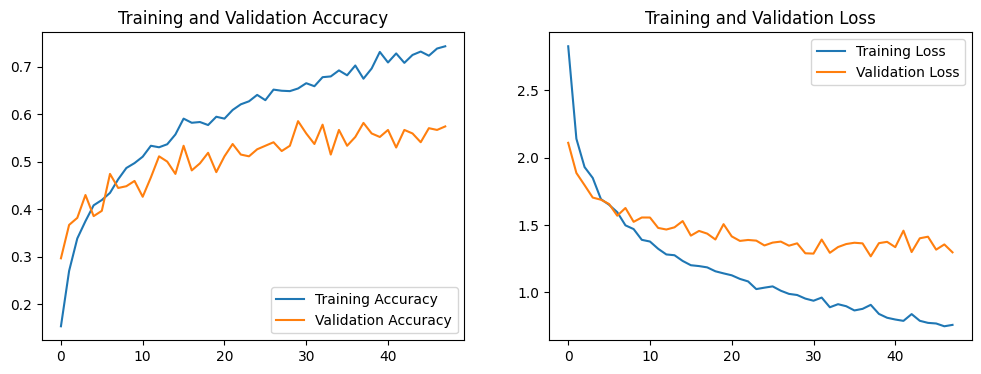

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc)) # Use len(acc) to get the actual number of epochs run

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# --- Optional: Fine-tuning ---
# Unfreeze some layers of the base model
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100 # Example: Unfreeze layers from the 100th layer onwards
                   # For MobileNetV2, a good starting point might be after a certain block.
                   # You'll need to inspect base_model.summary() to choose this.

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# model.summary() # Check which layers are trainable

# Continue training (fine-tuning)
FINE_TUNE_EPOCHS = 30 # Train for a few more epochs
TOTAL_EPOCHS = EPOCHS + FINE_TUNE_EPOCHS

history_fine_tune = model.fit(
    train_generator,
    epochs=TOTAL_EPOCHS,
    initial_epoch=history.epoch[-1] + 1, # Start from where the previous training stopped
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# Save the fine-tuned model
model.save('celebrity_face_recognition_model_fine_tuned.h5')

# Plot the fine-tuning results (append to previous history)
# acc += history_fine_tune.history['accuracy']
# val_acc += history_fine_tune.history['val_accuracy']
# loss += history_fine_tune.history['loss']
# val_loss += history_fine_tune.history['val_loss']

# epochs_range_fine_tune = range(TOTAL_EPOCHS)

#  plt.figure(figsize=(12, 4))
#  plt.subplot(1, 2, 1)
#  plt.plot(epochs_range_fine_tune, acc, label='Training Accuracy')
#  plt.plot(epochs_range_fine_tune, val_acc, label='Validation Accuracy')
#  plt.legend(loc='lower right')
#  plt.title('Training and Validation Accuracy (with Fine-Tuning)')

#  plt.subplot(1, 2, 2)
#  plt.plot(epochs_range_fine_tune, loss, label='Training Loss')
#  plt.plot(epochs_range_fine_tune, val_loss, label='Validation Loss')
#  plt.legend(loc='upper right')
#  plt.title('Training and Validation Loss (with Fine-Tuning)')
#  plt.show()

Epoch 49/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5191 - loss: 1.6217
Epoch 49: val_loss did not improve from 1.26715
40/40 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - accuracy: 0.5205 - loss: 1.6148 - val_accuracy: 0.5185 - val_loss: 1.6893
Epoch 50/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.7532 - loss: 0.6722
Epoch 50: val_loss did not improve from 1.26715
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 570ms/step - accuracy: 0.7531 - loss: 0.6726 - val_accuracy: 0.5593 - val_loss: 1.6387
Epoch 51/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.8060 - loss: 0.5715
Epoch 51: val_loss did not improve from 1.26715
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 569ms/step - accuracy: 0.8063 - loss: 0.5708 - val_accuracy: 0.6296 - val_loss: 1.3401
Epoch 52/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.8829 - loss: 0.3873
Epoch 52: val_loss improved from 1.26715 to 1.07320, saving model to best_face_recognition_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 610ms/step - accuracy: 0.

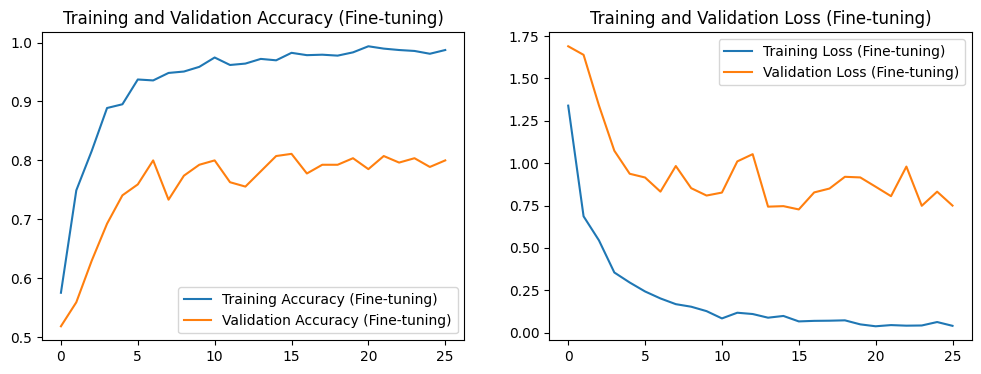

In [ ]:
# --- Plot Fine-tuning Results ---
acc_fine = history_fine_tune.history['accuracy']
val_acc_fine = history_fine_tune.history['val_accuracy']
loss_fine = history_fine_tune.history['loss']
val_loss_fine = history_fine_tune.history['val_loss']

epochs_range_fine = range(len(acc_fine)) # Use the length of the accuracy list

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_fine, acc_fine, label='Training Accuracy (Fine-tuning)')
plt.plot(epochs_range_fine, val_acc_fine, label='Validation Accuracy (Fine-tuning)')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Fine-tuning)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_fine, loss_fine, label='Training Loss (Fine-tuning)')
plt.plot(epochs_range_fine, val_loss_fine, label='Validation Loss (Fine-tuning)')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Fine-tuning)')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 918ms/step - accuracy: 0.8160 - loss: 0.9474
Test Loss: 0.8561
Test Accuracy: 0.8148


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions
pred_probs = model.predict(test_generator)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print report
print(classification_report(true_classes, pred_classes, target_names=class_labels))


9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
                    precision    recall  f1-score   support

    Angelina Jolie       0.79      0.73      0.76        15
         Brad Pitt       0.79      0.73      0.76        15
 Denzel Washington       0.83      1.00      0.91        15
      Hugh Jackman       0.70      0.93      0.80        15
 Jennifer Lawrence       0.79      0.73      0.76        15
       Johnny Depp       0.79      0.73      0.76        15
      Kate Winslet       0.50      0.73      0.59        15
 Leonardo DiCaprio       0.83      1.00      0.91        15
         Megan Fox       0.93      0.93      0.93        15
   Natalie Portman       0.92      0.80      0.86        15
     Nicole Kidman       0.93      0.93      0.93        15
  Robert Downey Jr       0.80      0.80      0.80        15
    Sandra Bullock       1.00      0.60      0.75        15
Scarlett Johansson       0.87      0.87      0.87        30
        Tom Cruise       0.83      0.67      0.74        15
  